# XGBoost
## Mobile Price Classification - ML Assignment 2

This notebook implements **XGBoost** for mobile price classification.

### Dataset:
- 20 features (mobile specifications)
- 2000 samples
- 4 classes (price ranges: 0, 1, 2, 3)

### Evaluation Metrics:
- Accuracy
- AUC Score
- Precision
- Recall
- F1 Score
- MCC Score

In [25]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef,
    confusion_matrix, classification_report
)
import pickle
import warnings
warnings.filterwarnings('ignore')

print('✓ All libraries imported successfully')

✓ All libraries imported successfully


In [26]:
# Load dataset
print('Loading dataset...')
df = pd.read_csv('../data/train.csv')

print(f'✓ Dataset loaded: {df.shape}')
print(f'  Features: {df.shape[1] - 1}')
print(f'  Samples: {df.shape[0]}')

# Display first few rows
df.head()

Loading dataset...
✓ Dataset loaded: (1399, 21)
  Features: 20
  Samples: 1399


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


Target Distribution:
price_range
0    345
1    339
2    353
3    362
Name: count, dtype: int64


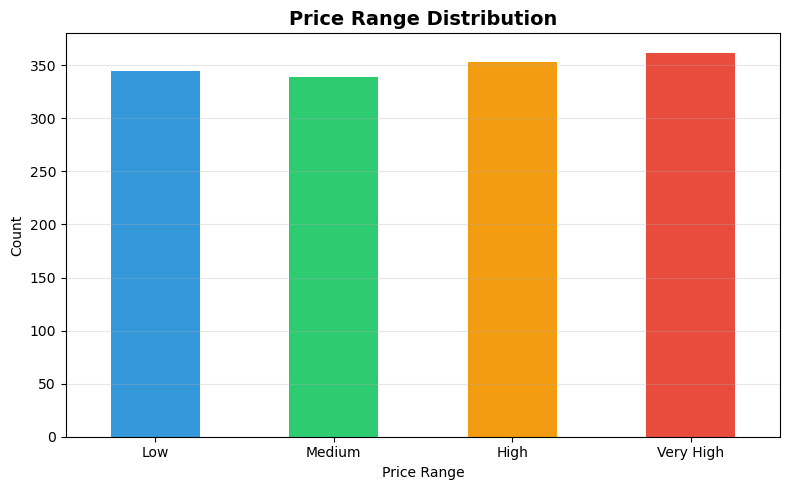

In [27]:
# Target distribution
print('Target Distribution:')
print(df['price_range'].value_counts().sort_index())

# Visualize
plt.figure(figsize=(8, 5))
df['price_range'].value_counts().sort_index().plot(
    kind='bar',
    color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
)
plt.title('Price Range Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Price Range')
plt.ylabel('Count')
plt.xticks([0, 1, 2, 3], ['Low', 'Medium', 'High', 'Very High'], rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
# Separate features and target
X = df.drop('price_range', axis=1)
y = df['price_range']

# Split data (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training samples: {X_train.shape[0]}')
print(f'Testing samples: {X_test.shape[0]}')

Training samples: 1119
Testing samples: 280


In [29]:
# Feature Scaling: Not required for tree-based models
print('✓ Feature scaling not required for this model')

✓ Feature scaling not required for this model


In [30]:
# Train XGBoost
print('Training model...')

model = XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1)
model.fit(X_train, y_train)

print('✓ Training completed!')

Training model...
✓ Training completed!


In [31]:
# Make predictions
y_pred = model.predict(X_test)

# Get probabilities if available
if hasattr(model, 'predict_proba'):
    y_pred_proba = model.predict_proba(X_test)
else:
    y_pred_proba = None

print('✓ Predictions completed')

✓ Predictions completed


In [32]:
# Calculate all metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
mcc = matthews_corrcoef(y_test, y_pred)

# AUC Score
if y_pred_proba is not None:
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
    auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='weighted')
else:
    auc = 0.0

# Display
print('='*60)
print('EVALUATION METRICS - XGBOOST')
print('='*60)
print(f'Accuracy:  {accuracy:.4f}')
print(f'AUC Score: {auc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1 Score:  {f1:.4f}')
print(f'MCC Score: {mcc:.4f}')
print('='*60)

EVALUATION METRICS - XGBOOST
Accuracy:  0.9179
AUC Score: 0.9929
Precision: 0.9195
Recall:    0.9179
F1 Score:  0.9171
MCC Score: 0.8914


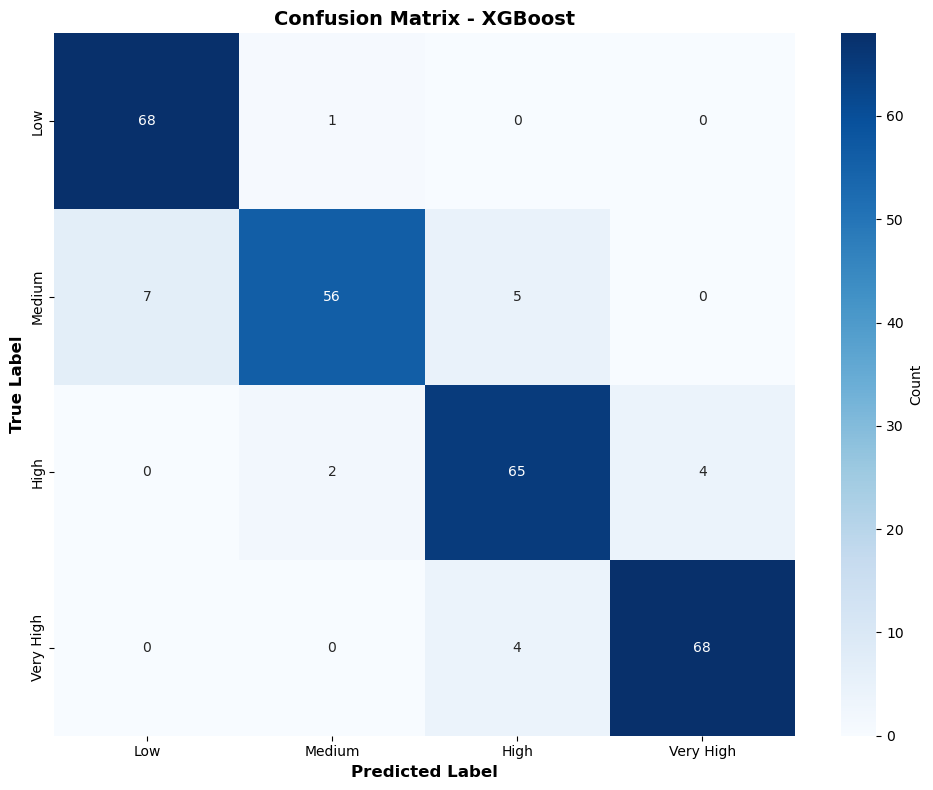

In [33]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High', 'Very High'],
            yticklabels=['Low', 'Medium', 'High', 'Very High'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - XGBoost', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [34]:
# Classification Report
print('Classification Report:')
print('='*60)
report = classification_report(
    y_test, y_pred,
    target_names=['Low', 'Medium', 'High', 'Very High'],
    digits=4
)
print(report)

Classification Report:
              precision    recall  f1-score   support

         Low     0.9067    0.9855    0.9444        69
      Medium     0.9492    0.8235    0.8819        68
        High     0.8784    0.9155    0.8966        71
   Very High     0.9444    0.9444    0.9444        72

    accuracy                         0.9179       280
   macro avg     0.9197    0.9172    0.9168       280
weighted avg     0.9195    0.9179    0.9171       280



In [35]:
# XGBoost Analysis
print(f'Number of Estimators: {model.n_estimators}')
print(f'Max Depth: {model.max_depth}')
print(f'Learning Rate: {model.learning_rate}')

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print('\nTop 10 Features:')
print(feature_importance.head(10))

Number of Estimators: None
Max Depth: None
Learning Rate: None

Top 10 Features:
          Feature  Importance
13            ram    0.392549
0   battery_power    0.130263
11      px_height    0.091208
12       px_width    0.086430
3        dual_sim    0.032687
16      talk_time    0.025633
6      int_memory    0.025480
9         n_cores    0.024738
8       mobile_wt    0.024001
7           m_dep    0.021586


In [36]:
# Save model and results
with open('../model/artifacts/xgboost.pkl', 'wb') as f:
    pickle.dump(model, f)
print('✓ Model saved to: xgboost.pkl')

# Save results
results_df = pd.DataFrame([{
    'Model': 'XGBoost',
    'Accuracy': round(accuracy, 4),
    'AUC': round(auc, 4),
    'Precision': round(precision, 4),
    'Recall': round(recall, 4),
    'F1': round(f1, 4),
    'MCC': round(mcc, 4)
}])

results_df.to_csv('../model/submission_csv/xgboost_results.csv', index=False)
print('✓ Results saved')

results_df

✓ Model saved to: xgboost.pkl
✓ Results saved


,Model,Accuracy,AUC,Precision,Recall,F1,MCC
0,XGBoost,0.9179,0.9929,0.9195,0.9179,0.9171,0.8914
